# 📚 FAISS-Based Vector Store & Semantic Retrieval with LLM
This notebook demonstrates how to build a semantic search engine from PDF documents using FAISS, SentenceTransformers, UMAP, and Groq LLM.

## 📄 1. Load and Extract Text from PDF

In [32]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


In [33]:
# Load PDFs from /content folder in Colab (upload required)
glob_path = "/content/*.pdf"
text = ""
for pdf_path in glob.glob(glob_path):
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

print("Preview of extracted text:", text[:500])


Preview of extracted text: School  of 
Management  and Law 
Abteilung Operations  & Services  
Development  & Services  
1.Schwerpunktthemen Abteilung  General  Management
Institut  für Marketing  Management  (IMM)  
•Strategisches  Kundenbeziehungsmanagement
•Product  Management
•Behavioral Marketing
•Customer  Experience Management
•Communication  & Branding
•Digital Marketing
Institut  für Wirtschaftsinformatik  (IWI)  
•Digitale Transformation auf den Ebenen der betrieblichen Prozesse, der Kundenin
teraktionen  sowie 


## ✂️ 2. Split Text into Chunks

In [34]:
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
chunks = splitter.split_text(text)
print(f"Total chunks: {len(chunks)}")
print("First chunk preview:", chunks[0][:300])


Total chunks: 62
First chunk preview: School  of 
Management  and Law 
Abteilung Operations  & Services  
Development  & Services  
1.Schwerpunktthemen Abteilung  General  Management
Institut  für Marketing  Management  (IMM)  
•Strategisches  Kundenbeziehungsmanagement
•Product  Management
•Behavioral Marketing
•Customer  Experience Ma


## 🔢 3. Tokenize with SentenceTransformer Models

In [35]:

from langchain.text_splitter import SentenceTransformersTokenTextSplitter

model_name = "paraphrase-multilingual-MiniLM-L12-v2"
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name=model_name)

token_split_texts = []
for chunk in chunks:
    token_split_texts += token_splitter.split_text(chunk)

print(f"Total token-based chunks: {len(token_split_texts)}")


Total token-based chunks: 252


## 🔐 4. Generate Embeddings

In [36]:

from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer(model_name)
chunk_embeddings = embedding_model.encode(token_split_texts, convert_to_numpy=True)
chunk_embeddings.shape


(252, 384)

## 🧠 5. Create FAISS Vector Index

In [37]:

import faiss
import pickle

d = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

# Save index (optional)
faiss.write_index(index, "/content/faiss_index.index")
with open("/content/chunks_mapping.pkl", "wb") as f:
    pickle.dump(token_split_texts, f)


Number of embeddings in FAISS index: 252


## 📉 6. Project Embeddings with UMAP

In [38]:

import umap.umap_ as umap
import tqdm

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, transformer):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings)):
        umap_embeddings[i] = transformer.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
  0%|          | 0/252 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/

## ❓ 7. Query & Retrieve Similar Chunks

In [39]:

def retrieve(query, k=5):
    query_embedding = embedding_model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

query = "Was ist ein Plagiat?"
results, result_embeddings, distances = retrieve(query)
print("Top result:", results[0])


Top result: schaftlichkeit studentischer Arbe iten gewährleisten . Was gilt als Plagiat? Von einem Plagiat spricht man, wenn ein fremdes Werk1 ganz oder teilweise ohne Quellenangabe übernommen und als eigenes Werk ausgegeben wird. Demzufolge fallen beispielsweise folgende Handlungen einer Verfasserin/eines Verfassers unter den Plagiatsbegriff: - Ein fremdes Werk wird unter dem eigenen Namen eingereicht ( Vollplagiat ); - ein Werk, das von einer andern Person ganz oder teilweise im Auftrag erstellt wurde, wird unter dem eigenen Namen eingereicht (sog.


## 📊 8. Visualize Results

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

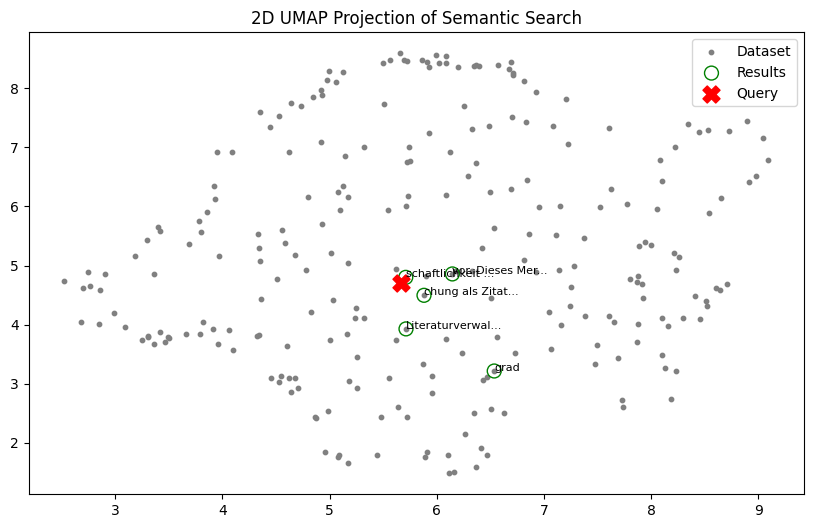

In [40]:

import matplotlib.pyplot as plt

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)
query_embedding = embedding_model.encode([query], convert_to_numpy=True)
projected_query = project_embeddings(query_embedding, umap_transform)

def shorten(text, n=15):
    return (text[:n] + "...") if len(text) > n else text

plt.figure(figsize=(10, 6))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color="gray", label="Dataset")
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, edgecolors='g', facecolors='none', label="Results")
plt.scatter(projected_query[:, 0], projected_query[:, 1], s=150, color='red', marker='X', label="Query")

for i, text in enumerate(results):
    plt.annotate(shorten(text), (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]), fontsize=8)

plt.legend()
plt.title("2D UMAP Projection of Semantic Search")
plt.show()


## 🤖 9. Ask Groq LLM with Retrieved Context

In [41]:

import os
from dotenv import load_dotenv
from groq import Groq

load_dotenv()
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

context_block = "\n".join(results)
prompt = f"""Nutze den folgenden Kontext, um die Frage zu beantworten: '{query}'
Kontext:
{context_block}
"""

completion = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[{"role": "user", "content": prompt}]
)

print("Antwort vom LLM:")
print(completion.choices[0].message.content)


Antwort vom LLM:
Ein Plagiat ist, wenn ein fremdes Werk ganz oder teilweise ohne Quellenangabe übernommen und als eigenes Werk ausgegeben wird.
